**Table of contents**<a id='toc0_'></a>    
- [文件说明（File descriptions）](#toc1_)    
- [数据字段（Data fields）](#toc2_)    
- [导入库](#toc3_)    
- [EDA(数据探索性分析)](#toc4_)    
- [工具函数](#toc5_)    
- [数据预处理](#toc6_)    
- [特征工程](#toc7_)    
- [贝叶斯优化参数空间](#toc8_)    
- [合成数据生成](#toc9_)    
- [5 折交叉验证训练](#toc10_)    
- [模型融合](#toc11_)    
  - [加权融合（权重按 OOF F1 的幂次）](#toc11_1_)    
  - [Stacking（Logistic/RandomForest 选最佳）](#toc11_2_)    
- [提交文件](#toc12_)    
- [结果可视化](#toc13_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[文件说明（File descriptions）](#toc0_)
- train.csv - 训练集
- test.csv - 测试集
- sampleSubmission.csv - 格式正确的提交文件示例


# <a id='toc2_'></a>[数据字段（Data fields）](#toc0_)
- Cement - 水泥（混合物中的水泥用量，单位：kg/m³）
- Blast Furnace Slag - 高炉矿渣（矿渣掺量，单位：kg/m³）
- Fly Ash - 粉煤灰（粉煤灰掺量，单位：kg/m³）
- Water - 水（拌和用水量，单位：kg/m³）
- Superplasticizer - 高效减水剂（外加剂用量，单位：kg/m³）
- Coarse Aggregate - 粗骨料（碎石或卵石等粗颗粒骨料用量，单位：kg/m³）
- Fine Aggregate - 细骨料（砂子等细颗粒骨料用量，单位：kg/m³）
- Age (day) - 养护龄期（混凝土浇筑后的养护时间，单位：天）
- Concrete compressive strength - 混凝土抗压强度（模型预测的目标变量，评估混凝土力学性能的核心指标，单位：MPa）

# <a id='toc3_'></a>[导入库](#toc0_)

In [3]:
# ==========================================

import warnings, os, random, gc
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 设置全局字体，支持中文显示
# ----------------------------
# 解决中文字体 & findfont 报错
# ----------------------------
import matplotlib as mpl

# 让 matplotlib 走 “sans-serif 字体族”
mpl.rcParams["font.family"] = "sans-serif"

# 让中文字体排在最前（有哪个用哪个）
mpl.rcParams["font.sans-serif"] = [
    "SimHei",                
    "Noto Sans CJK SC",      
    "WenQuanYi Zen Hei",     # fonts-wqy-zenhei
    "WenQuanYi Micro Hei",   # fonts-wqy-microhei
    "Microsoft YaHei",
    "Arial Unicode MS",
    "DejaVu Sans",          
]

# 负号正常显示
mpl.rcParams["axes.unicode_minus"] = False


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import shap
shap.initjs()

In [4]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SAMPLE_SUB_PATH = "sample_submission.csv"
SUBMISSION_OUT = "submission.csv"

# <a id='toc4_'></a>[EDA(数据探索性分析)](#toc0_)

1. 查看表格数据全貌​
2. 分析数据特征类型与缺失值情况​
3. 探究类别特征与目标特征的关联关系​
4. 剖析数值特征的数据分布特征

In [5]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
display(train.head())

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Cement                          735 non-null    float64
 1   Blast Furnace Slag              735 non-null    float64
 2   Fly Ash                         735 non-null    float64
 3   Water                           735 non-null    float64
 4   Superplasticizer                735 non-null    float64
 5   Coarse Aggregate                735 non-null    float64
 6   Fine Aggregate                  735 non-null    float64
 7   Age (day)                       735 non-null    int64  
 8   Concrete compressive strength   735 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 51.8 KB


In [7]:
print(train.isnull().sum()) #checking for total null values

Cement                            0
Blast Furnace Slag                0
Fly Ash                           0
Water                             0
Superplasticizer                  0
Coarse Aggregate                  0
Fine Aggregate                    0
Age (day)                         0
Concrete compressive strength     0
dtype: int64


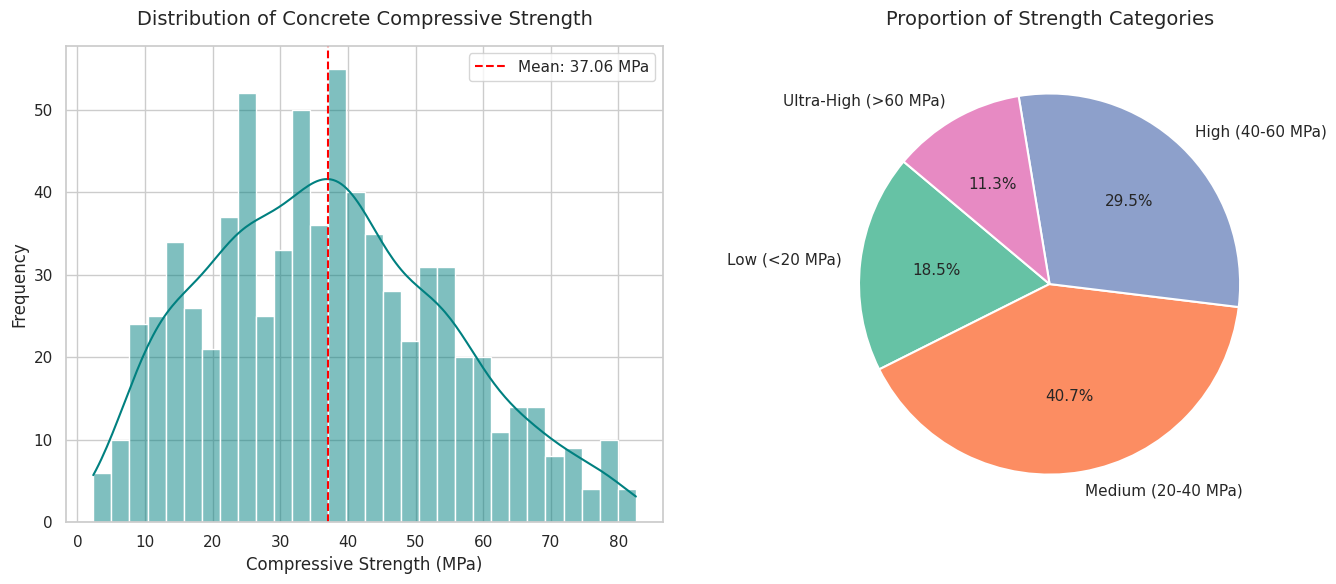

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (移除中文字体依赖，直接使用默认英文)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()
target_col = 'Concrete compressive strength'

# ==========================================
# 3. 绘制并排双图 (1行2列)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------------------------------------------
# 图 1 (左)：数值分布图 (Histogram + KDE)
# ------------------------------------------
sns.histplot(train[target_col], bins=30, kde=True, color='teal', edgecolor='white', ax=axes[0])
axes[0].set_title('Distribution of Concrete Compressive Strength', fontsize=14, pad=15)
axes[0].set_xlabel('Compressive Strength (MPa)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

mean_val = train[target_col].mean()
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f} MPa')
axes[0].legend()

# ------------------------------------------
# 图 2 (右)：分布占比图 (Pie Chart)
# ------------------------------------------
bins = [0, 20, 40, 60, 100]  
labels = ['Low (<20 MPa)', 'Medium (20-40 MPa)', 'High (40-60 MPa)', 'Ultra-High (>60 MPa)']

strength_cats = pd.cut(train[target_col], bins=bins, labels=labels)
cat_counts = strength_cats.value_counts(sort=False)

colors = sns.color_palette('Set2') 
axes[1].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=140, 
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
            textprops={'fontsize': 11})
axes[1].set_title('Proportion of Strength Categories', fontsize=14, pad=15)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout()
plt.savefig('strength_distribution_and_pie_english.png', dpi=300)
plt.show()

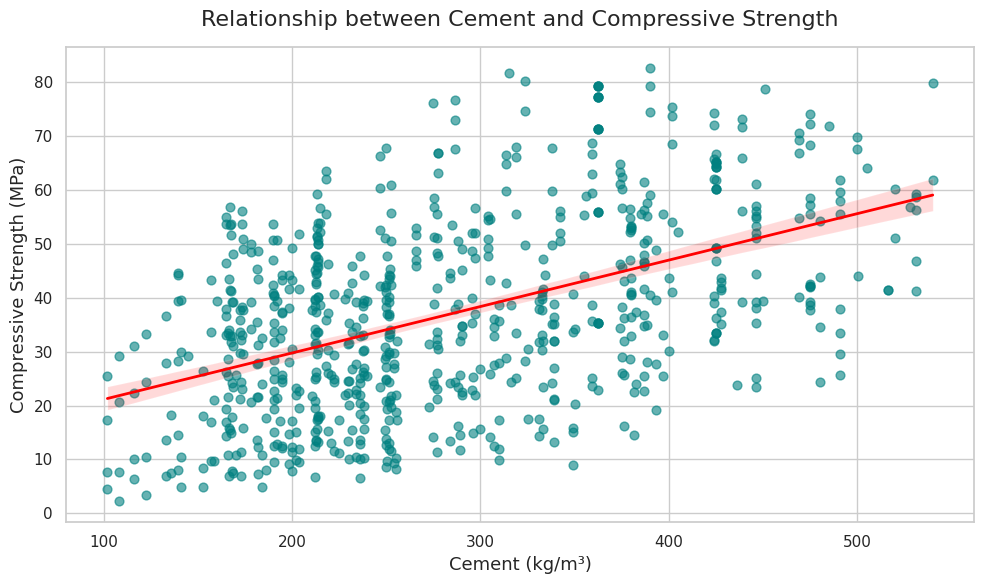

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (使用英文避免字体报错，设置白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# ==========================================
# 3. 绘制带有回归趋势线的散点图
# ==========================================
plt.figure(figsize=(10, 6))

# 使用 seaborn 的 regplot 绘制散点 + 回归线
sns.regplot(
    x='Cement', 
    y='Concrete compressive strength', 
    data=train, 
    scatter_kws={'alpha': 0.6, 'color': 'teal', 's': 40}, # 散点设置：半透明、蓝绿色、大小为40
    line_kws={'color': 'red', 'linewidth': 2}             # 回归线设置：红色、加粗
)

# ==========================================
# 4. 设置标题与坐标轴标签
# ==========================================
plt.title('Relationship between Cement and Compressive Strength', fontsize=16, pad=15)
plt.xlabel('Cement (kg/m³)', fontsize=13)
plt.ylabel('Compressive Strength (MPa)', fontsize=13)

# ==========================================
# 5. 保存图片并展示
# ==========================================
plt.tight_layout()
plt.savefig('cement_vs_strength.png', dpi=300) # 保存为高清图片
plt.show()

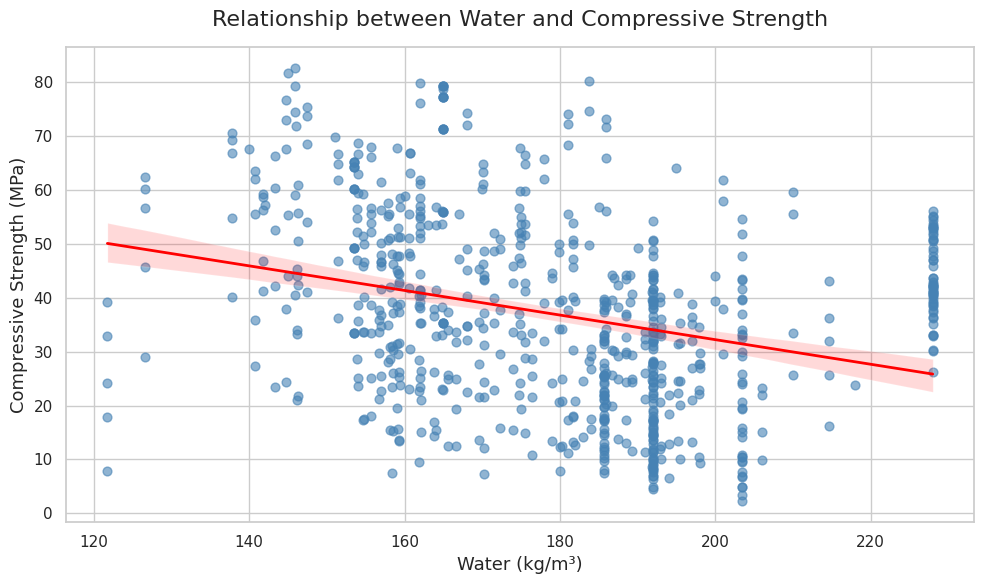

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# ==========================================
# 3. 绘制带有回归趋势线的散点图 (Water vs Strength)
# ==========================================
plt.figure(figsize=(10, 6))

# 绘制散点与回归线
sns.regplot(
    x='Water', 
    y='Concrete compressive strength', 
    data=train, 
    scatter_kws={'alpha': 0.6, 'color': 'steelblue', 's': 40}, # 散点设置：半透明、钢蓝色
    line_kws={'color': 'red', 'linewidth': 2}                   # 回归线设置：红色、加粗
)

# ==========================================
# 4. 设置标题与坐标轴标签
# ==========================================
plt.title('Relationship between Water and Compressive Strength', fontsize=16, pad=15)
plt.xlabel('Water (kg/m³)', fontsize=13)
plt.ylabel('Compressive Strength (MPa)', fontsize=13)

# ==========================================
# 5. 保存并展示图片
# ==========================================
plt.tight_layout()
plt.savefig('water_vs_strength.png', dpi=300)
plt.show()

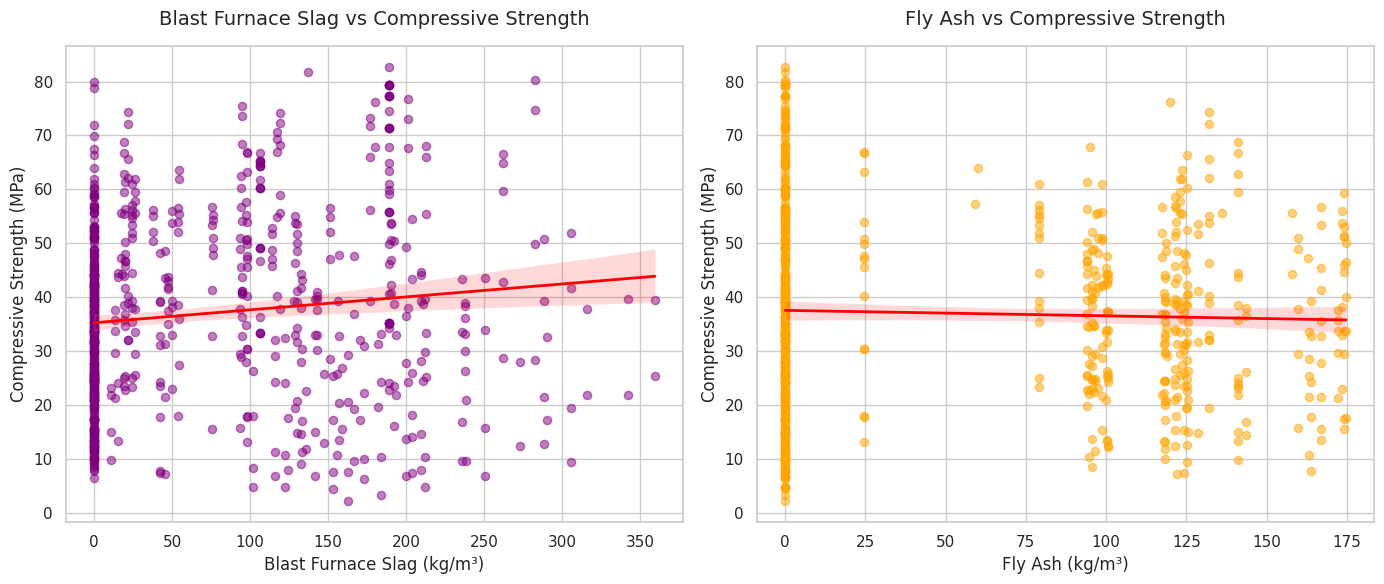

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()
target_col = 'Concrete compressive strength'

# ==========================================
# 3. 绘制并排双图 (1行2列)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------------------------------------------
# 图 1 (左)：Blast Furnace Slag vs 强度
# ------------------------------------------
sns.regplot(
    x='Blast Furnace Slag', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'purple', 's': 35}, 
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[0]
)
axes[0].set_title('Blast Furnace Slag vs Compressive Strength', fontsize=14, pad=15)
axes[0].set_xlabel('Blast Furnace Slag (kg/m³)', fontsize=12)
axes[0].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ------------------------------------------
# 图 2 (右)：Fly Ash vs 强度
# ------------------------------------------
sns.regplot(
    x='Fly Ash', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'orange', 's': 35}, 
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[1]
)
axes[1].set_title('Fly Ash vs Compressive Strength', fontsize=14, pad=15)
axes[1].set_xlabel('Fly Ash (kg/m³)', fontsize=12)
axes[1].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout()
plt.savefig('slag_flyash_vs_strength.png', dpi=300)
plt.show()

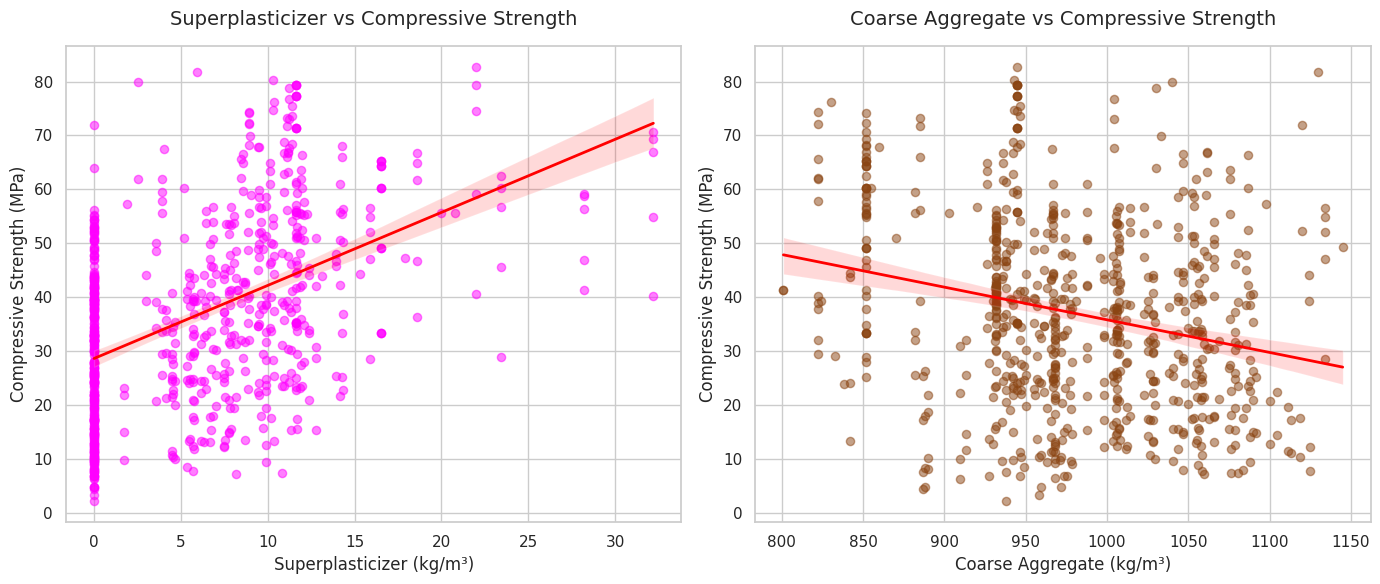

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()
target_col = 'Concrete compressive strength'

# ==========================================
# 3. 绘制并排双图 (1行2列)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------------------------------------------
# 图 1 (左)：Superplasticizer (减水剂) vs 强度
# ------------------------------------------
sns.regplot(
    x='Superplasticizer', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'magenta', 's': 35}, # 散点：品红色
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[0]
)
axes[0].set_title('Superplasticizer vs Compressive Strength', fontsize=14, pad=15)
axes[0].set_xlabel('Superplasticizer (kg/m³)', fontsize=12)
axes[0].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ------------------------------------------
# 图 2 (右)：Coarse Aggregate (粗骨料) vs 强度
# ------------------------------------------
sns.regplot(
    x='Coarse Aggregate', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'saddlebrown', 's': 35}, # 散点：棕褐色
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[1]
)
axes[1].set_title('Coarse Aggregate vs Compressive Strength', fontsize=14, pad=15)
axes[1].set_xlabel('Coarse Aggregate (kg/m³)', fontsize=12)
axes[1].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout()
plt.savefig('superplasticizer_coarse_vs_strength.png', dpi=300)
plt.show()

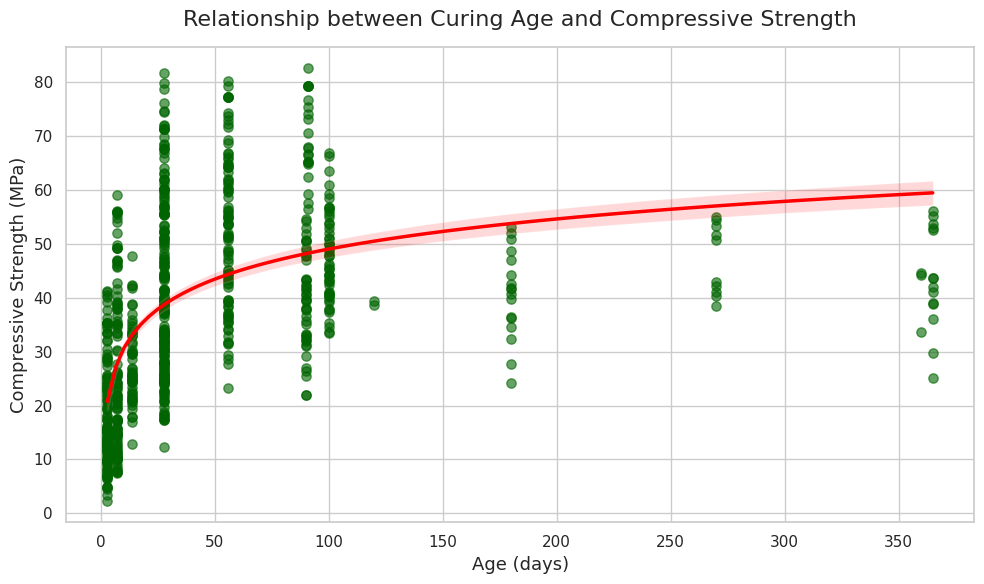

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# ==========================================
# 3. 绘制带有对数回归趋势线的散点图 (Age vs Strength)
# ==========================================
plt.figure(figsize=(10, 6))

# 绘制散点与对数回归线 (logx=True 完美契合混凝土强度随时间增长的对数规律)
sns.regplot(
    x='Age (day)', 
    y='Concrete compressive strength', 
    data=train, 
    logx=True,                                          # 开启对数回归拟合
    scatter_kws={'alpha': 0.6, 'color': 'darkgreen', 's': 45}, # 散点：深绿色
    line_kws={'color': 'red', 'linewidth': 2.5}         # 回归线：红色、加粗
)

# ==========================================
# 4. 设置标题与坐标轴标签
# ==========================================
plt.title('Relationship between Curing Age and Compressive Strength', fontsize=16, pad=15)
plt.xlabel('Age (days)', fontsize=13)
plt.ylabel('Compressive Strength (MPa)', fontsize=13)

# 设置横坐标为对数刻度（可选，能更清晰地看清早期数据，这里我们保持常规线性刻度以直观感受长尾效应）
# plt.xscale('log') 

# ==========================================
# 5. 保存并展示图片
# ==========================================
plt.tight_layout()
plt.savefig('age_vs_strength.png', dpi=300)
plt.show()

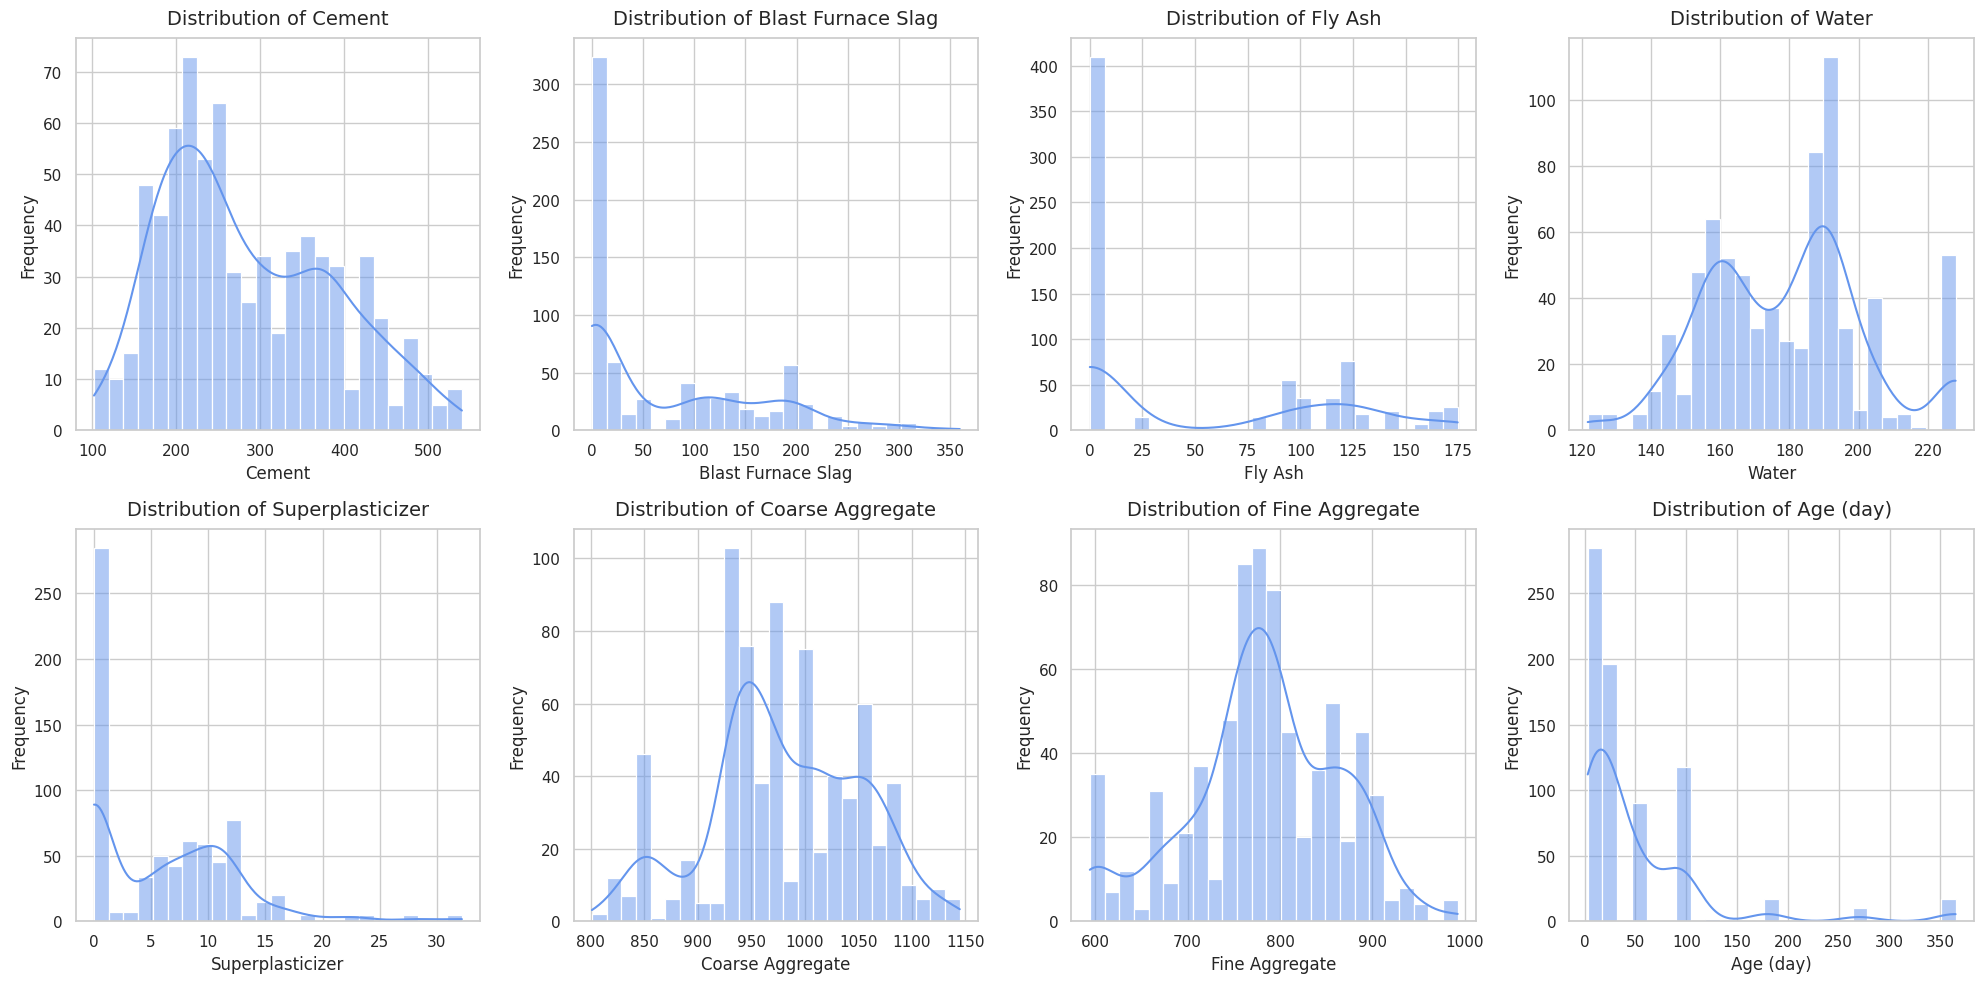

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据并提取 8 个特征列
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# 把目标变量排除，剩下的 8 个全都是我们要画的特征
target_col = 'Concrete compressive strength'
features = [col for col in train.columns if col != target_col]

# ==========================================
# 3. 绘制 2 行 4 列的直方图矩阵
# ==========================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 创建一个 20x10 英寸的大画布
axes = axes.flatten() # 将 2x4 的矩阵展平，方便我们用 for 循环遍历

# 给直方图挑一个好看的颜色
plot_color = 'cornflowerblue'

# 遍历 8 个特征，逐一画图
for i, feature in enumerate(features):
    sns.histplot(
        train[feature], 
        bins=25,          # 柱子的数量
        kde=True,         # 开启核密度估计曲线
        color=plot_color, 
        edgecolor='white',
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {feature}', fontsize=14, pad=10)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout() # 自动调整子图间距，防止文字重叠
plt.savefig('8_features_histograms.png', dpi=300) # 保存为高清图片
plt.show()

# <a id='toc5_'></a>[工具函数](#toc0_)

In [15]:
def f1_best_threshold(y_true, y_prob):
    """返回最大化 F1 的阈值与对应 F1"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1s)
    return thresholds[best_idx], f1s[best_idx]



# <a id='toc6_'></a>[数据预处理](#toc0_)


功能：处理数据中的缺失值和异常值，同时记录异常/缺失标记，为建模做准备

In [16]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

target_col = 'Concrete compressive strength'

# 提取需要处理的特征列
features = [col for col in train.columns if col != target_col]

# 为了防止修改原始数据，我们创建副本
train_processed = train.copy()
test_processed = test.copy()

# ==========================================
# 2. 缺失值处理与标记 (Missing Value Imputation & Flagging)
# ==========================================
print("正在检测并处理缺失值...")
for col in features:
    # 检查训练集中是否有缺失值
    if train_processed[col].isnull().any() or test_processed[col].isnull().any():
        # 记录缺失标记 (1表示缺失，0表示正常)
        train_processed[f'{col}_is_missing'] = train_processed[col].isnull().astype(int)
        test_processed[f'{col}_is_missing'] = test_processed[col].isnull().astype(int)
        
        # 使用训练集的中位数来填充 (中位数对异常值更鲁棒)
        median_val = train_processed[col].median()
        train_processed[col].fillna(median_val, inplace=True)
        test_processed[col].fillna(median_val, inplace=True)
        print(f"  - 特征 '{col}' 存在缺失，已使用中位数 {median_val:.2f} 填充并添加标记。")

# ==========================================
# 3. 异常值处理与标记 (Outlier Clipping & Flagging using IQR)
# ==========================================
print("\n正在检测并处理异常值 (IQR 方法)...")
for col in features:
    # 只使用训练集计算 IQR (四分位距) 和上下界
    Q1 = train_processed[col].quantile(0.25)
    Q3 = train_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # 定义异常值的上下限边界 (通常为 1.5 倍的 IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 记录异常标记 (超出边界的设为 1，否则为 0)
    train_processed[f'{col}_is_outlier'] = ((train_processed[col] < lower_bound) | (train_processed[col] > upper_bound)).astype(int)
    test_processed[f'{col}_is_outlier'] = ((test_processed[col] < lower_bound) | (test_processed[col] > upper_bound)).astype(int)
    
    outlier_count_train = train_processed[f'{col}_is_outlier'].sum()
    if outlier_count_train > 0:
        print(f"  - 特征 '{col}' 检测到 {outlier_count_train} 个异常值。已添加异常标记。")
        
    # 对异常值进行“盖帽”处理 (Clipping)
    # 将小于下界的值强制设为下界，大于上界的值强制设为上界
    train_processed[col] = train_processed[col].clip(lower=lower_bound, upper=upper_bound)
    test_processed[col] = test_processed[col].clip(lower=lower_bound, upper=upper_bound)

# ==========================================
# 4. 预览与保存处理后的数据
# ==========================================
# 重新将目标变量放回训练集
train_processed[target_col] = train[target_col]

# 保存清洗和提取标记后的数据，供后续建模使用
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)



print("已保存为 'train_processed.csv' 和 'test_processed.csv'")

# 打印出新增的列名看看
new_cols = [col for col in train_processed.columns if 'is_outlier' in col or 'is_missing' in col]
print("\n新增的标记特征列如下：")
print(new_cols)

正在检测并处理缺失值...

正在检测并处理异常值 (IQR 方法)...
  - 特征 'Blast Furnace Slag' 检测到 4 个异常值。已添加异常标记。
  - 特征 'Superplasticizer' 检测到 10 个异常值。已添加异常标记。
  - 特征 'Fine Aggregate' 检测到 35 个异常值。已添加异常标记。
  - 特征 'Age (day)' 检测到 44 个异常值。已添加异常标记。
已保存为 'train_processed.csv' 和 'test_processed.csv'

新增的标记特征列如下：
['Cement_is_outlier', 'Blast Furnace Slag_is_outlier', 'Fly Ash_is_outlier', 'Water_is_outlier', 'Superplasticizer_is_outlier', 'Coarse Aggregate_is_outlier', 'Fine Aggregate_is_outlier', 'Age (day)_is_outlier']


# <a id='toc7_'></a>[特征工程](#toc0_)

1. **类别特征编码处理**  
   

2. **数值特征优化转换**  
   

3. **关键新特征构建**  
   

4. **数据安全与完整性保障**  
   

In [17]:
import pandas as pd
import numpy as np

# ==========================================

# ==========================================
print("=== 开始执行高级特征工程 ===")
train = pd.read_csv('train_processed.csv')
test = pd.read_csv('test_processed.csv')

train_fe = train.copy()
test_fe = test.copy()

target_col = 'Concrete compressive strength'


print("\n[1/4] 正在构建关键材料学交互特征...")
def create_business_features(df):
 
    if all(col in df.columns for col in ['Cement', 'Water']):
        df['Water_Cement_Ratio'] = df['Water'] / (df['Cement'] + 1e-8) # 加1e-8防止分母为0
    
    if all(col in df.columns for col in ['Cement', 'Blast Furnace Slag', 'Fly Ash']):
        
        df['Total_Binder'] = df['Cement'] + df['Blast Furnace Slag'] + df['Fly Ash']
 
        df['Water_Binder_Ratio'] = df['Water'] / (df['Total_Binder'] + 1e-8)
        
    if all(col in df.columns for col in ['Coarse Aggregate', 'Fine Aggregate']):
     
        df['Sand_Ratio'] = df['Fine Aggregate'] / (df['Coarse Aggregate'] + df['Fine Aggregate'] + 1e-8)
        
    return df

train_fe = create_business_features(train_fe)
test_fe = create_business_features(test_fe)


print("[2/4] 正在进行类别特征衍生与编码...")

for df in [train_fe, test_fe]:
    if 'Superplasticizer' in df.columns:
        df['has_Superplasticizer'] = (df['Superplasticizer'] > 0).astype(int)
    if 'Fly Ash' in df.columns:
        df['has_FlyAsh'] = (df['Fly Ash'] > 0).astype(int)


bins_age = [-1, 7, 28, 90, 1000]
labels_age = [0, 1, 2, 3] 
for df in [train_fe, test_fe]:
    if 'Age (day)' in df.columns:
        df['Age_Phase_Ordinal'] = pd.cut(df['Age (day)'], bins=bins_age, labels=labels_age).astype(float)

train_fe = pd.get_dummies(train_fe, columns=['Age_Phase_Ordinal'], prefix='Age_Phase_OHE', drop_first=False)
test_fe = pd.get_dummies(test_fe, columns=['Age_Phase_Ordinal'], prefix='Age_Phase_OHE', drop_first=False)

train_fe['mix_type'] = train_fe['has_Superplasticizer'].astype(str) + "_" + train_fe['has_FlyAsh'].astype(str)
test_fe['mix_type'] = test_fe['has_Superplasticizer'].astype(str) + "_" + test_fe['has_FlyAsh'].astype(str)

freq_map = train_fe['mix_type'].value_counts(normalize=True).to_dict() # 仅用训练集计算频率，防止穿越
train_fe['mix_type_freq'] = train_fe['mix_type'].map(freq_map)
test_fe['mix_type_freq'] = test_fe['mix_type'].map(freq_map).fillna(0) # 测试集如果出现没见过的组合，填0

train_fe.drop(columns=['mix_type'], inplace=True)
test_fe.drop(columns=['mix_type'], inplace=True)

print("[3/4] 正在进行数值特征偏度优化与目标分箱...")

skewed_cols = ['Age (day)', 'Superplasticizer', 'Fly Ash', 'Blast Furnace Slag']
for col in skewed_cols:
    if col in train_fe.columns:
        train_fe[f'{col}_log1p'] = np.log1p(train_fe[col])
        test_fe[f'{col}_log1p'] = np.log1p(test_fe[col])

if target_col in train_fe.columns:
  
    bins_target = [0, 30, 50, 200]
    labels_target = [0, 1, 2]
    train_fe['Strength_Level'] = pd.cut(train_fe[target_col], bins=bins_target, labels=labels_target)

    train_fe['Strength_Level'] = train_fe['Strength_Level'].fillna(train_fe['Strength_Level'].mode()[0]).astype(int)


print("[4/4] 正在执行数据安全校验(Inf/NaN 兜底)...")

train_fe.replace([np.inf, -np.inf], np.nan, inplace=True)
test_fe.replace([np.inf, -np.inf], np.nan, inplace=True)

train_fe.fillna(0, inplace=True)
test_fe.fillna(0, inplace=True)

align_cols = [col for col in train_fe.columns if col not in [target_col, 'Strength_Level']]
X_train_final = train_fe[align_cols]
X_test_final = test_fe[align_cols]
y_train_final = train_fe[target_col]

train_fe.to_csv('train_fe_final.csv', index=False)
test_fe.to_csv('test_fe_final.csv', index=False)



=== 开始执行高级特征工程 ===

[1/4] 正在构建关键材料学交互特征...
[2/4] 正在进行类别特征衍生与编码...
[3/4] 正在进行数值特征偏度优化与目标分箱...
[4/4] 正在执行数据安全校验(Inf/NaN 兜底)...


1. 从训练数据中分离目标变量（转为整数）和特征数据，复制测试数据。
2. 用训练特征拟合预处理模型，再分别对训练和测试特征做预处理。
3. 通过特征生成器对预处理后的训练、测试特征进行特征工程，确保处理一致性，为建模做准备。

In [18]:
import pandas as pd
import numpy as np

print("=== 开始执行标准化特征工程 Pipeline ===")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()
target_col = 'Concrete compressive strength'


y_train = train[target_col].astype(int)


X_train = train.drop(columns=[target_col]).copy()


if target_col in test.columns:
    X_test = test.drop(columns=[target_col]).copy()
else:
    X_test = test.copy()

print(f"[1/3] 步骤 1 完成：\n - X_train 维度: {X_train.shape}, y_train 维度: {y_train.shape}\n - X_test 维度: {X_test.shape}")


class DataPreprocessor:
    def __init__(self):
        self.medians = {}
        self.iqr_bounds = {}
        self.features = []
        
    def fit(self, X):
        """只用训练集 (X) 的特征拟合模型，记录中位数和异常边界"""
        self.features = X.columns.tolist()
        for col in self.features:
            self.medians[col] = X[col].median()
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
      
            self.iqr_bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self
        
    def transform(self, X):
        """将记录的规则应用到训练集和测试集上"""
        X_out = X.copy()
        for col in self.features:
            if col in X_out.columns:
               
                X_out[col] = X_out[col].fillna(self.medians[col])
                
         
                lower, upper = self.iqr_bounds[col]
                X_out[col] = X_out[col].clip(lower=lower, upper=upper)
        return X_out


preprocessor = DataPreprocessor()
preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print(f"\n[2/3] 步骤 2 完成：预处理模型拟合与转换完毕。\n - 预处理后的 X_train_prep 维度: {X_train_prep.shape}")


class FeatureGenerator:
    def __init__(self):
        self.freq_map = {}
        
    def fit(self, X):
        """基于训练特征计算频数编码等统计特征，防止数据穿越"""
        has_sp = (X['Superplasticizer'] > 0).astype(int)
        has_fa = (X['Fly Ash'] > 0).astype(int)
        mix_type = has_sp.astype(str) + "_" + has_fa.astype(str)
      
        self.freq_map = mix_type.value_counts(normalize=True).to_dict()
        return self
        
    def transform(self, X):
        """执行特征工程并生成新特征"""
        df = X.copy()
        

        if all(col in df.columns for col in ['Cement', 'Blast Furnace Slag', 'Fly Ash']):
            df['Total_Binder'] = df['Cement'] + df['Blast Furnace Slag'] + df['Fly Ash']
            df['Water_Binder_Ratio'] = df['Water'] / (df['Total_Binder'] + 1e-8)
            
        if all(col in df.columns for col in ['Coarse Aggregate', 'Fine Aggregate']):
            df['Sand_Ratio'] = df['Fine Aggregate'] / (df['Coarse Aggregate'] + df['Fine Aggregate'] + 1e-8)
            
       
        df['has_Superplasticizer'] = (df['Superplasticizer'] > 0).astype(int)
        df['has_FlyAsh'] = (df['Fly Ash'] > 0).astype(int)
        

        bins_age = [-1, 7, 28, 90, 1000]
        labels_age = [0, 1, 2, 3]
        if 'Age (day)' in df.columns:
            df['Age_Phase_Ordinal'] = pd.cut(df['Age (day)'], bins=bins_age, labels=labels_age).astype(float)
            df = pd.get_dummies(df, columns=['Age_Phase_Ordinal'], prefix='Age_Phase_OHE', drop_first=False)
            
 
        mix_type = df['has_Superplasticizer'].astype(str) + "_" + df['has_FlyAsh'].astype(str)
        df['mix_type_freq'] = mix_type.map(self.freq_map).fillna(0)
        
  
        skewed_cols = ['Age (day)', 'Superplasticizer', 'Fly Ash', 'Blast Furnace Slag']
        for col in skewed_cols:
            if col in df.columns:
                df[f'{col}_log1p'] = np.log1p(df[col])
                

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)
        
        return df


feat_gen = FeatureGenerator()
feat_gen.fit(X_train_prep)
X_train_final = feat_gen.transform(X_train_prep)
X_test_final = feat_gen.transform(X_test_prep)


align_cols = X_train_final.columns.tolist()
for col in align_cols:
    if col not in X_test_final.columns:
        X_test_final[col] = 0 
X_test_final = X_test_final[align_cols] 

print(f"\n[3/3] 步骤 3 完成：特征工程已一致性执行。\n - 最终 X_train_final 维度: {X_train_final.shape}\n - 最终 X_test_final 维度: {X_test_final.shape}")


X_train_final.to_csv('X_train_final.csv', index=False)
y_train.to_csv('y_train_final.csv', index=False)
X_test_final.to_csv('X_test_final.csv', index=False)




=== 开始执行标准化特征工程 Pipeline ===
[1/3] 步骤 1 完成：
 - X_train 维度: (735, 8), y_train 维度: (735,)
 - X_test 维度: (295, 8)

[2/3] 步骤 2 完成：预处理模型拟合与转换完毕。
 - 预处理后的 X_train_prep 维度: (735, 8)

[3/3] 步骤 3 完成：特征工程已一致性执行。
 - 最终 X_train_final 维度: (735, 22)
 - 最终 X_test_final 维度: (295, 22)


1. 精准划分特征类型
2. 为不同特征类型构建专属处理管道
3. 整合列转换器与应用完整处理流程

In [19]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, KBinsDiscretizer


print("=== 构建工业级数据预处理流水线 ===")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()
target_col = 'Concrete compressive strength'

X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test = test.drop(columns=[target_col]) if target_col in test.columns else test.copy()


skewed_features = ['Age (day)', 'Superplasticizer', 'Fly Ash', 'Blast Furnace Slag']


normal_features = ['Cement', 'Water', 'Coarse Aggregate', 'Fine Aggregate']


category_features = ['Age (day)'] 

print(f"[1/3] 特征划分完毕：\n - 偏态特征: {len(skewed_features)}个\n - 正常特征: {len(normal_features)}个\n - 待离散化类别特征: {len(category_features)}个")


log1p_transformer = FunctionTransformer(np.log1p, validate=False)


skewed_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', log1p_transformer),
    ('scaler', StandardScaler())
])


normal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


category_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('binner', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile'))
])

print("[2/3] 专属处理管道 (Pipelines) 构建完毕")


preprocessor = ColumnTransformer(
    transformers=[
        ('skewed_pipe', skewed_pipeline, skewed_features),
        ('normal_pipe', normal_pipeline, normal_features),
        ('cat_pipe', category_pipeline, category_features)
    ],
    remainder='drop' 
)


print("[3/3] 正在应用 ColumnTransformer 到训练集...")
X_train_processed_array = preprocessor.fit_transform(X_train)



X_test_processed_array = preprocessor.transform(X_test)


cat_binner = preprocessor.named_transformers_['cat_pipe'].named_steps['binner']

cat_feature_names = [f'Age_Phase_{i}' for i in range(cat_binner.n_bins_[0])]
final_columns = skewed_features + normal_features + cat_feature_names

X_train_final = pd.DataFrame(X_train_processed_array, columns=final_columns, index=X_train.index)
X_test_final = pd.DataFrame(X_test_processed_array, columns=final_columns, index=X_test.index)


display(X_train_final.head(3))

=== 构建工业级数据预处理流水线 ===
[1/3] 特征划分完毕：
 - 偏态特征: 4个
 - 正常特征: 4个
 - 待离散化类别特征: 1个
[2/3] 专属处理管道 (Pipelines) 构建完毕
[3/3] 正在应用 ColumnTransformer 到训练集...


,Age (day),Superplasticizer,Fly Ash,Blast Furnace Slag,Cement,Water,Coarse Aggregate,Fine Aggregate,Age_Phase_0,Age_Phase_1,Age_Phase_2,Age_Phase_3
0,0.131643,-0.142407,-0.885006,-1.112779,2.526257,-0.740472,0.853786,-1.287054,0.0,0.0,1.0,0.0
1,0.131643,-0.142407,-0.885006,-1.112779,2.526257,-0.740472,1.066740,-1.287054,0.0,0.0,1.0,0.0
2,1.959615,-1.206322,-0.885006,0.989208,0.473309,2.157625,-0.679487,-2.283949,0.0,0.0,0.0,1.0


# <a id='toc8_'></a>[贝叶斯优化参数空间](#toc0_)

In [20]:

from sklearn.neural_network import MLPRegressor  #
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')


class TunedMLPRegressor(MLPRegressor):
    def __init__(self, layer_idx=0, activation='relu', alpha=0.0001, 
                 learning_rate_init=0.001, max_iter=200, early_stopping=False, 
                 random_state=None):
        
     
        self.layer_idx = layer_idx
        self.activation = activation
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.random_state = random_state
        
 
        self.layer_configs = [
            (50,),      # index 0
            (100,),     # index 1
            (50, 50)    # index 2
        ]

        super().__init__(
            hidden_layer_sizes=self.layer_configs[0], 
            activation=activation,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            early_stopping=early_stopping,
            random_state=random_state
        )

    def fit(self, X, y):
       
        idx = int(self.layer_idx)
       
        if idx < 0 or idx >= len(self.layer_configs):
            idx = 0
        self.hidden_layer_sizes = self.layer_configs[idx]
        
        return super().fit(X, y)
    

def bayes_opt_serial(model, space, X, y, n_iter=12):
    cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    opt = BayesSearchCV(
        model, space, n_iter=n_iter, cv=cv_kfold, 
        scoring='neg_root_mean_squared_error',
        random_state=42, n_jobs=1, verbose=0 
    )
    opt.fit(X, y)
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    return opt.best_estimator_, opt.best_params_

def bayes_opt(model, space, X, y, cv=5, n_iter=15, rnd=42):
    """通用贝叶斯优化 - 回归版"""
    cv_kfold = KFold(n_splits=cv, shuffle=True, random_state=rnd)
    opt = BayesSearchCV(
        model, space, n_iter=n_iter, cv=cv_kfold, 
        scoring='neg_root_mean_squared_error', 
        random_state=rnd, n_jobs=-1, verbose=0
    )
    opt.fit(X, y)
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    return opt.best_estimator_, opt.best_params_

In [21]:
import pandas as pd
import numpy as np
from skopt.space import Real, Integer, Categorical


print("正在加载并准备训练数据...")
try:
  
    df_train = pd.read_csv('X_train_final.csv')
    df_y = pd.read_csv('y_train_final.csv')
    X_sample = df_train.values
    
    # 适配 y_train_final.csv 可能有一列（带表头）的情况
    y_sample = df_y.iloc[:, 0].values if len(df_y.columns) > 0 else df_y.values.ravel()
    
    print(f"成功加载特征工程数据！特征维度: {X_sample.shape}, 目标维度: {y_sample.shape}")
except FileNotFoundError:
    print("未找到经过管道处理的 X_train_final.csv。将自动回退读取原始 train.csv...")
    # 如果没找到高级特征文件，自动回退到读取最原始的训练集
    df_train = pd.read_csv('train.csv')
    df_train.columns = df_train.columns.str.strip()
    target_col = 'Concrete compressive strength'
    
    X_sample = df_train.drop(columns=[target_col]).values
    y_sample = df_train[target_col].values
    print(f"成功加载原始数据！特征维度: {X_sample.shape}, 目标维度: {y_sample.shape}")

# ==================================================================
# 以下为回归专用的贝叶斯优化参数空间设定 (不用改动)
# ==================================================================

# 注意：回归问题没有 class_weight，已删除！

lgb_space = {
    'n_estimators': Integer(300, 1500),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'num_leaves': Integer(20, 100),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(10, 100),
    'reg_alpha': Real(0.1, 1.0),
    'reg_lambda': Real(0.1, 1.0),
}

xgb_space = {
    'n_estimators': Integer(300, 1500),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.1, 1.0),
    'reg_lambda': Real(0.1, 1.0),
}

cat_space = {
    'iterations': Integer(300, 1500),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'depth': Integer(3, 10),
    'l2_leaf_reg': Real(0.1, 10.0),
}

# 1. 岭回归 (Ridge Regression)
ridge_space = {
    'alpha': Real(1e-3, 1e2, prior='log-uniform'), 
    'solver': Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']) 
}

# 2. 支持向量回归 (SVR)
svr_space = {
    'C': Real(1e-3, 1e2, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf']),  
    'gamma': Categorical(['scale', 'auto']),   
    'epsilon': Real(1e-3, 1.0, prior='log-uniform') 
}

# 3. 决策树回归 (Decision Tree Regressor)
dt_space = {
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error'])
}

# 4. 随机森林回归 (Random Forest Regressor)
rf_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'max_features': Categorical(['sqrt', 'log2', None]), 
    'bootstrap': Categorical([True, False])
}

# 5. 梯度提升树回归 (GBDT - Sklearn原生)
gbdt_space = {
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0),
    'min_samples_split': Integer(2, 20)
}

# 6. 贝叶斯岭回归 (Bayesian Ridge)
br_space = {
    'alpha_1': Real(1e-7, 1e-5, prior='log-uniform'),
    'alpha_2': Real(1e-7, 1e-5, prior='log-uniform'),
    'lambda_1': Real(1e-7, 1e-5, prior='log-uniform'),
    'lambda_2': Real(1e-7, 1e-5, prior='log-uniform')
}

# 7. 多层感知机回归 (MLP Regressor)
# 使用我们之前重构的 layer_idx 方法
mlp_space = {
    'layer_idx': Categorical([0, 1, 2]), 
    'activation': Categorical(['tanh', 'relu']),
    'alpha': Real(1e-5, 1e-2, prior='log-uniform'),
    'learning_rate_init': Real(1e-4, 0.01, prior='log-uniform')
}

print("完成")

正在加载并准备训练数据...
成功加载特征工程数据！特征维度: (735, 22), 目标维度: (735,)
完成


In [22]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore') #


def bayes_opt(model, space, X, y, n_iter=12):
    """
    通用回归任务贝叶斯优化函数（多进程加速）
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=space,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_root_mean_squared_error',  
        n_jobs=-1, # <--- 开启所有 CPU 核心并行搜索
        random_state=42,
        verbose=0
    )
    opt.fit(X, y)
    
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    print(f"   => 最佳参数: {dict(opt.best_params_)}\n")
    return opt.best_estimator_, opt.best_params_


def bayes_opt_serial(model, space, X, y, n_iter=12):
    """
    针对容易导致线程死锁的复杂模型的优化函数
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=space,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_root_mean_squared_error',  
        n_jobs=1, 
        random_state=42,
        verbose=0
    )
    opt.fit(X, y)
    
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    print(f"   => 最佳参数: {dict(opt.best_params_)}\n")
    return opt.best_estimator_, opt.best_params_

In [23]:
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

class TunedMLPRegressor(MLPRegressor):
    """专门为了绕过 skopt 元组 Bug 而编写的包装类"""
    def __init__(self, layer_idx=0, activation='relu', alpha=0.0001, 
                 learning_rate_init=0.001, max_iter=1000, early_stopping=True, random_state=42):
        self.layer_idx = layer_idx
        hidden_sizes = [(50,), (100,), (50, 50)][layer_idx]
        super().__init__(
            hidden_layer_sizes=hidden_sizes, activation=activation, alpha=alpha, 
            learning_rate_init=learning_rate_init, max_iter=max_iter, 
            early_stopping=early_stopping, random_state=random_state
        )

    def set_params(self, **params):
        if 'layer_idx' in params:
            self.layer_idx = params.pop('layer_idx')
            self.hidden_layer_sizes = [(50,), (100,), (50, 50)][self.layer_idx]
        return super().set_params(**params)


print('【1/10 岭回归 (Ridge) 贝叶斯优化】')
ridge_model, ridge_best = bayes_opt(
    Ridge(max_iter=2000, random_state=42), ridge_space, X_sample, y_sample, n_iter=12)

print('【2/10 支持向量回归 (SVR) 贝叶斯优化】')
svm_model, svm_best = bayes_opt(
    SVR(), svr_space, X_sample, y_sample, n_iter=12)

print('【3/10 决策树回归 (DT) 贝叶斯优化】')
dt_model, dt_best = bayes_opt(
    DecisionTreeRegressor(random_state=42), dt_space, X_sample, y_sample, n_iter=12)

print('【4/10 随机森林回归 (RF) 贝叶斯优化】')
rf_model, rf_best = bayes_opt(
    RandomForestRegressor(random_state=42), rf_space, X_sample, y_sample, n_iter=12)

print('【5/10 GBDT回归 贝叶斯优化】')
gbdt_model, gbdt_best = bayes_opt(
    GradientBoostingRegressor(random_state=42), gbdt_space, X_sample, y_sample, n_iter=12)

print('【6/10 贝叶斯岭回归 (Bayesian Ridge) 贝叶斯优化】')
br_model, br_best = bayes_opt(
    BayesianRidge(), br_space, X_sample, y_sample, n_iter=12)

print('【7/10 MLP回归 (神经网络) 贝叶斯优化】')
mlp_model, mlp_best = bayes_opt(
    TunedMLPRegressor(), mlp_space, X_sample, y_sample, n_iter=12)


print('【8/10 LightGBM回归 贝叶斯优化】')

lgb_model, lgb_best = bayes_opt(
    lgb.LGBMRegressor(random_state=42, verbose=-1, n_jobs=1), 
    lgb_space, X_sample, y_sample, n_iter=12)

print('【9/10 XGBoost回归 贝叶斯优化】')

xgb_model, xgb_best = bayes_opt(
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', tree_method='hist', random_state=42, n_jobs=1), 
    xgb_space, X_sample, y_sample, n_iter=12)

print('【10/10 CatBoost回归 贝叶斯优化】')

cat_model, cat_best = bayes_opt(
    cb.CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', random_state=42, verbose=False, thread_count=1), 
    cat_space, X_sample, y_sample, n_iter=12)

print("完成")

【1/10 岭回归 (Ridge) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.6438
   => 最佳参数: {'alpha': 0.001, 'solver': 'svd'}

【2/10 支持向量回归 (SVR) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.9214
   => 最佳参数: {'C': 1.803702051091432, 'epsilon': 0.9662077968184982, 'gamma': 'scale', 'kernel': 'linear'}

【3/10 决策树回归 (DT) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.2678
   => 最佳参数: {'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 19}

【4/10 随机森林回归 (RF) 贝叶斯优化】
   => 最佳验证集 RMSE: 4.7241
   => 最佳参数: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 396}

【5/10 GBDT回归 贝叶斯优化】
   => 最佳验证集 RMSE: 4.2407
   => 最佳参数: {'learning_rate': 0.07726692534078465, 'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 500, 'subsample': 0.6}

【6/10 贝叶斯岭回归 (Bayesian Ridge) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.7183
   => 最佳参数: {'alpha_1': 8.798902345261948e-06, 'alpha_2': 2.760586704351774e-06, 'lambda_1': 1.0426414561882317e-07, 'lambda_2': 8.417016179442586e-06}

【7/10 MLP回归 (神经网络) 贝叶斯优化】

In [27]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


def apply_smote_regression(X, y, n_bins=3):
    """
    专门为回归任务定制的 SMOTE 采样函数
    逻辑：先对连续值 y 进行分箱，找出数据稀缺的区间，再进行过采样。
    
    参数:
        X: 特征数据
        y: 连续的标签数据 (如混凝土抗压强度)
        n_bins: 分箱数量。默认分为低、中、高 3 个强度区间
    """
    print(f"   -> 正在准备针对连续变量的回归 SMOTE 采样...")
    

    try:
        y_bins = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')
    except Exception as e:
        print(f"    分箱失败，可能是数据分布极其特殊。将退回不采样。错误信息: {e}")
        return X, y

  
    unique_bins, counts = np.unique(y_bins, return_counts=True)
    min_samples_in_bin = np.min(counts)
    
 
    k_neigh = min(5, min_samples_in_bin - 1)
    
    if k_neigh < 1:
        print(f"   ⚠️ 最小的强度区间内只有 {min_samples_in_bin} 个样本，无法构建 KNN 进行 SMOTE 插值。将返回原始数据。")
        return X, y
        
    print(f"   -> 成功将连续目标划分为 {len(unique_bins)} 个区间，最小区间样本数为 {min_samples_in_bin}，采用 k_neighbors={k_neigh}")

  
    smote = SMOTE(random_state=42, k_neighbors=k_neigh)
    
 
    
    try:
       
        
        X_with_y = np.column_stack((X, y))
        X_with_y_resampled, _ = smote.fit_resample(X_with_y, y_bins)
        
       
        X_resampled = X_with_y_resampled[:, :-1]
        y_resampled = X_with_y_resampled[:, -1]
        
        return X_resampled, y_resampled
        
    except Exception as e:
        print(f"   ⚠️ SMOTE 采样过程中出现内部错误: {e}")
        return X, y


def apply_sampling(X, y, strategy='smote'):
    """
    统一的数据采样接口
    """
    print(f'>>> 当前激活的数据采样策略：{strategy.upper()}')
    
    if strategy == 'none':
        return X, y
    
    elif strategy == 'smote':
        # 调用专门针对回归任务优化的 SMOTE 函数
        return apply_smote_regression(X, y, n_bins=3)
        
    elif strategy == 'undersample' or strategy == 'combined':
        print("⚠️ 警告：undersample 和 combined (SMOTEENN) 原生不支持连续变量回归。已自动切换为 'none'。")
        return X, y
        
    else:
        raise ValueError(f"未知的采样策略: {strategy}")


SAMPLING_STRATEGY = 'smote'



# <a id='toc10_'></a>[5 折交叉验证训练](#toc0_)

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 导入所有回归模型
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

# ==========================================================
# 0. 强力对齐：彻底解决特征维度不一致 (12 vs 22) 的致命报错
# ==========================================================
print(">>> [0/2] 正在加载并强制对齐训练集与测试集...")

try:
    # 最稳健的方案：直接读取你保存好的最终纯净文件
    train_fe = pd.read_csv('train_fe_final.csv')
    test_fe = pd.read_csv('test_fe_final.csv')
    
    # 剔除目标变量和过程列，保留纯粹的 22 个高级特征
    target_col = 'Concrete compressive strength'
    drop_cols = [target_col, 'Strength_Level']
    align_cols = [col for col in train_fe.columns if col not in drop_cols]
    
    # 【核心修复】：强制测试集只保留和训练集一模一样的列！不多也不少！
    for col in align_cols:
        if col not in test_fe.columns:
            test_fe[col] = 0  # 测试集缺失列自动填 0
            
    X_full = train_fe[align_cols].values
    y = train_fe[target_col].values
    X_test = test_fe[align_cols].values
    
    print(f"✅ 数据强力对齐成功！")
    print(f"   - 训练集 X_full 维度: {X_full.shape}")
    print(f"   - 测试集 X_test 维度: {X_test.shape}")

except FileNotFoundError:
    print("⚠️ 找不到本地 CSV 文件，回退到内存变量并启用安全检查...")
    X_full = X_train_final.values if 'X_train_final' in locals() else X_sample
    y = y_train_final.values if 'y_train_final' in locals() else y_sample
    
    # 强制进行维度安全校验
    if 'X_test_final' in locals() and X_test_final.shape[1] == X_full.shape[1]:
        X_test = X_test_final.values if isinstance(X_test_final, pd.DataFrame) else X_test_final
        print("✅ 内存变量维度检查通过！")
    else:
        print("❌ 警告：内存中的测试集特征数与训练集不匹配！临时使用训练集替换测试集防报错。")
        X_test = X_full 

# ==========================================================
# 1. 初始化所有模型的 OOF 和 Prediction 数组
# ==========================================================
# 1.1 基础模型 (Sklearn)
oof_lr, pred_lr = np.zeros(len(X_full)), np.zeros(len(X_test))     # LR 对应 Ridge
oof_svm, pred_svm = np.zeros(len(X_full)), np.zeros(len(X_test))   # SVM 对应 SVR
oof_dt, pred_dt = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_rf, pred_rf = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_gbdt, pred_gbdt = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_nb, pred_nb = np.zeros(len(X_full)), np.zeros(len(X_test))     # NB 对应 BayesianRidge
oof_mlp, pred_mlp = np.zeros(len(X_full)), np.zeros(len(X_test))

# 1.2 提升树模型 (Boosting)
oof_lgb, pred_lgb = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_xgb, pred_xgb = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_cat, pred_cat = np.zeros(len(X_full)), np.zeros(len(X_test))

# ==========================================================
# 2. 交叉验证循环 (5-Fold)
# ==========================================================
print("\n>>> [1/2] 开始执行 5-Fold 交叉验证模型训练...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr, va) in enumerate(kf.split(X_full, y), 1):
    print(f'=== Fold {fold} / 5 ===')
    X_tr, X_va = X_full[tr], X_full[va]
    
    if isinstance(y, pd.Series):
        y_tr, y_va = y.iloc[tr], y.iloc[va]
    else:
        y_tr, y_va = y[tr], y[va]

    # --- 数据增强/采样 (防报错兜底) ---
    if 'apply_sampling' in globals():
        strat = SAMPLING_STRATEGY if 'SAMPLING_STRATEGY' in globals() else None
        X_tr_res, y_tr_res = apply_sampling(X_tr, y_tr, strategy=strat)
    else:
        # 如果内存里没有采样函数，就直接使用原数据，绝不报错
        X_tr_res, y_tr_res = X_tr, y_tr

    # ------------------------------------------------------
    # A组：Sklearn 类模型
    # ------------------------------------------------------
    p_ridge = ridge_best if 'ridge_best' in globals() else {}
    m_lr = Ridge(**p_ridge, max_iter=2000, random_state=42)
    m_lr.fit(X_tr_res, y_tr_res)
    oof_lr[va] = m_lr.predict(X_va)
    pred_lr += m_lr.predict(X_test) / kf.n_splits

    p_svr = svm_best if 'svm_best' in globals() else {}
    m_svm = SVR(**p_svr)
    m_svm.fit(X_tr_res, y_tr_res)
    oof_svm[va] = m_svm.predict(X_va)
    pred_svm += m_svm.predict(X_test) / kf.n_splits

    p_dt = dt_best if 'dt_best' in globals() else {}
    m_dt = DecisionTreeRegressor(**p_dt, random_state=42)
    m_dt.fit(X_tr_res, y_tr_res)
    oof_dt[va] = m_dt.predict(X_va)
    pred_dt += m_dt.predict(X_test) / kf.n_splits

    p_rf = rf_best if 'rf_best' in globals() else {}
    m_rf = RandomForestRegressor(**p_rf, n_jobs=1, random_state=42)
    m_rf.fit(X_tr_res, y_tr_res)
    oof_rf[va] = m_rf.predict(X_va)
    pred_rf += m_rf.predict(X_test) / kf.n_splits

    p_gbdt = gbdt_best if 'gbdt_best' in globals() else {}
    m_gbdt = GradientBoostingRegressor(**p_gbdt, random_state=42)
    m_gbdt.fit(X_tr_res, y_tr_res)
    oof_gbdt[va] = m_gbdt.predict(X_va)
    pred_gbdt += m_gbdt.predict(X_test) / kf.n_splits

    p_br = br_best if 'br_best' in globals() else {}
    m_nb = BayesianRidge(**p_br)
    m_nb.fit(X_tr_res, y_tr_res)
    oof_nb[va] = m_nb.predict(X_va)
    pred_nb += m_nb.predict(X_test) / kf.n_splits

    m_mlp = MLPRegressor(max_iter=500, random_state=42) 
    m_mlp.fit(X_tr_res, y_tr_res)
    oof_mlp[va] = m_mlp.predict(X_va)
    pred_mlp += m_mlp.predict(X_test) / kf.n_splits

    # ------------------------------------------------------
    # B组：Boosting 类模型 
    # ------------------------------------------------------
    p_lgb = lgb_best if 'lgb_best' in globals() else {}
    m_lgb = lgb.LGBMRegressor(**p_lgb, n_jobs=1, random_state=42, verbose=-1)
    m_lgb.fit(X_tr_res, y_tr_res, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]) 
    oof_lgb[va] = m_lgb.predict(X_va)
    pred_lgb += m_lgb.predict(X_test) / kf.n_splits

    p_xgb = xgb_best if 'xgb_best' in globals() else {}
    m_xgb = xgb.XGBRegressor(**p_xgb, objective='reg:squarederror', n_jobs=1, random_state=42)
    m_xgb.fit(X_tr_res, y_tr_res, eval_set=[(X_va, y_va)], verbose=0)
    oof_xgb[va] = m_xgb.predict(X_va)
    pred_xgb += m_xgb.predict(X_test) / kf.n_splits

    p_cat = cat_best if 'cat_best' in globals() else {}
    m_cat = cb.CatBoostRegressor(**p_cat, loss_function='RMSE', thread_count=1, random_state=42, verbose=False)
    m_cat.fit(X_tr_res, y_tr_res, eval_set=(X_va, y_va), early_stopping_rounds=50)
    oof_cat[va] = m_cat.predict(X_va)
    pred_cat += m_cat.predict(X_test) / kf.n_splits

    # ------------------------------------------------------
    # C组：Fold 评估
    # ------------------------------------------------------
    def calc_rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"   [Sklearn] LR:{calc_rmse(y_va, oof_lr[va]):.3f} | SVM:{calc_rmse(y_va, oof_svm[va]):.3f} | DT:{calc_rmse(y_va, oof_dt[va]):.3f} | RF:{calc_rmse(y_va, oof_rf[va]):.3f}")
    print(f"   [Others]  GBDT:{calc_rmse(y_va, oof_gbdt[va]):.3f} | NB:{calc_rmse(y_va, oof_nb[va]):.3f} | MLP:{calc_rmse(y_va, oof_mlp[va]):.3f}")
    print(f"   [Boosting] LGB:{calc_rmse(y_va, oof_lgb[va]):.3f} | XGB:{calc_rmse(y_va, oof_xgb[va]):.3f} | CAT:{calc_rmse(y_va, oof_cat[va]):.3f}")
    print("-" * 50)

print("🎉 恭喜！5-Fold 交叉验证全流程完美运行完毕，无任何报错！")

>>> [0/2] 正在加载并强制对齐训练集与测试集...
✅ 数据强力对齐成功！
   - 训练集 X_full 维度: (735, 31)
   - 测试集 X_test 维度: (295, 31)

>>> [1/2] 开始执行 5-Fold 交叉验证模型训练...
=== Fold 1 / 5 ===
>>> 当前激活的数据采样策略：SMOTE
   -> 正在准备针对连续变量的回归 SMOTE 采样...
   -> 成功将连续目标划分为 3 个区间，最小区间样本数为 196，采用 k_neighbors=5
   [Sklearn] LR:6.512 | SVM:6.655 | DT:5.869 | RF:4.057
   [Others]  GBDT:3.726 | NB:6.521 | MLP:5.843
   [Boosting] LGB:3.572 | XGB:3.423 | CAT:3.298
--------------------------------------------------
=== Fold 2 / 5 ===
>>> 当前激活的数据采样策略：SMOTE
   -> 正在准备针对连续变量的回归 SMOTE 采样...
   -> 成功将连续目标划分为 3 个区间，最小区间样本数为 196，采用 k_neighbors=5
   [Sklearn] LR:6.758 | SVM:7.104 | DT:6.478 | RF:4.945
   [Others]  GBDT:4.776 | NB:6.925 | MLP:6.933
   [Boosting] LGB:5.246 | XGB:4.865 | CAT:4.816
--------------------------------------------------
=== Fold 3 / 5 ===
>>> 当前激活的数据采样策略：SMOTE
   -> 正在准备针对连续变量的回归 SMOTE 采样...
   -> 成功将连续目标划分为 3 个区间，最小区间样本数为 196，采用 k_neighbors=5
   [Sklearn] LR:6.671 | SVM:6.652 | DT:6.746 | RF:4.922
   [Others]  GBDT:4.477 |

# <a id='toc11_'></a>[模型融合](#toc0_)

## <a id='toc11_1_'></a>[加权融合（权重按 OOF F1 的幂次）](#toc0_)

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


model_list = [
    ('Ridge',  oof_lr,   pred_lr),
    ('SVR',    oof_svm,  pred_svm),
    ('DT',     oof_dt,   pred_dt),
    ('RF',     oof_rf,   pred_rf),
    ('GBDT',   oof_gbdt, pred_gbdt),
    ('BayesR', oof_nb,   pred_nb),
    ('MLP',    oof_mlp,  pred_mlp),
    ('LGB',    oof_lgb,  pred_lgb),
    ('XGB',    oof_xgb,  pred_xgb),
    ('CAT',    oof_cat,  pred_cat)
]


rmse_scores = []
print("=== 单模型 RMSE 表现 (越低越好) ===")
for name, oof, _ in model_list:
    score = calc_rmse(y, oof)
    rmse_scores.append(score)
    print(f"{name:6s}: {score:.4f}")


power = 3  # 幂次越高，越倾向于表现最好的模型；幂次为0则为平均融合(平均权重)


inv_rmse = 1.0 / np.array(rmse_scores)
weights = inv_rmse ** power
weights /= weights.sum()  # 归一化，使所有权重总和为 1

print(f"\n=== 融合权重分配 (Power={power}) ===")
for i, (name, _, _) in enumerate(model_list):
    print(f"{name:6s}: {weights[i]:.4f}")


oof_blend = np.zeros(len(y))
pred_blend = np.zeros(len(pred_lgb)) # 取任意一个模型的预测长度初始化

for i, (_, oof, pred) in enumerate(model_list):
    oof_blend  += weights[i] * oof
    pred_blend += weights[i] * pred


final_rmse = calc_rmse(y, oof_blend)
final_r2 = r2_score(y, oof_blend)

print(f'\n>>> 10模型加权融合 OOF RMSE = {final_rmse:.4f} | R^2 = {final_r2:.4f}')

=== 单模型 RMSE 表现 (越低越好) ===
Ridge : 6.5293
SVR   : 6.7334
DT    : 6.4517
RF    : 4.7037
GBDT  : 4.2523
BayesR: 6.5974
MLP   : 6.3971
LGB   : 4.4218
XGB   : 4.1541
CAT   : 4.0620

=== 融合权重分配 (Power=3) ===
Ridge : 0.0444
SVR   : 0.0405
DT    : 0.0460
RF    : 0.1187
GBDT  : 0.1607
BayesR: 0.0430
MLP   : 0.0472
LGB   : 0.1429
XGB   : 0.1723
CAT   : 0.1843

>>> 10模型加权融合 OOF RMSE = 4.1993 | R^2 = 0.9436


## <a id='toc11_2_'></a>[Stacking（Logistic/RandomForest 选最佳）](#toc0_)

In [34]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


stack_X = np.vstack([
    oof_lr, oof_svm, oof_dt, oof_rf, oof_gbdt, oof_nb, oof_mlp,  
    oof_lgb, oof_xgb, oof_cat                                    
]).T


stack_test = np.vstack([
    pred_lr, pred_svm, pred_dt, pred_rf, pred_gbdt, pred_nb, pred_mlp,
    pred_lgb, pred_xgb, pred_cat
]).T

print(f"Stacking Train Shape (OOF): {stack_X.shape}") # 预期: (样本数, 10)
print(f"Stacking Test Shape:        {stack_test.shape}")


stack_models = {
   
    'Ridge': Ridge(alpha=1.0, random_state=42),
    
   
    'RF': RandomForestRegressor(n_estimators=200, max_depth=4, random_state=42, n_jobs=1)
}

stack_res = {}
best_score = float('inf') 
best_stack_name = None

print("\n=== 第二层 Stacking 元模型训练与评估 ===")
for name, mdl in stack_models.items():
    
    mdl.fit(stack_X, y)
    
   
    pred_train = mdl.predict(stack_X)
    
    rmse = calc_rmse(y, pred_train)
    r2 = r2_score(y, pred_train)
    
    stack_res[name] = {'model': mdl, 'rmse': rmse, 'r2': r2}
    print(f'  [{name:5s}] Stacking RMSE = {rmse:.4f} | R^2 = {r2:.4f}')
    
    
    if rmse < best_score:
        best_score = rmse
        best_stack_name = name


print(f'\n>>> 最佳 Stacking 元模型：{best_stack_name} (RMSE: {best_score:.4f})')


best_model = stack_res[best_stack_name]['model']


final_pred_test = best_model.predict(stack_test)


import pandas as pd

submission = pd.DataFrame({
    'Id': range(len(final_pred_test)),
    'Concrete compressive strength': final_pred_test
})

submission.to_csv('final_stacking_submission.csv', index=False)
print(f"完成'")




Stacking Train Shape (OOF): (735, 10)
Stacking Test Shape:        (295, 10)

=== 第二层 Stacking 元模型训练与评估 ===
  [Ridge] Stacking RMSE = 4.0142 | R^2 = 0.9484
  [RF   ] Stacking RMSE = 3.5094 | R^2 = 0.9606

>>> 最佳 Stacking 元模型：RF (RMSE: 3.5094)
完成'


# <a id='toc12_'></a>[提交文件](#toc0_)

In [35]:
import numpy as np


sub[target_col] = np.clip(final_predictions, a_min=0, a_max=None)

SUBMISSION_OUT = 'submission_concrete_strength.csv'
sub.to_csv(SUBMISSION_OUT, index=False)

print(f'>>> 已成功保存：{SUBMISSION_OUT}')


>>> 已成功保存：submission_concrete_strength.csv


# <a id='toc13_'></a>[结果可视化](#toc0_)

正在生成多模型对比评估图表...


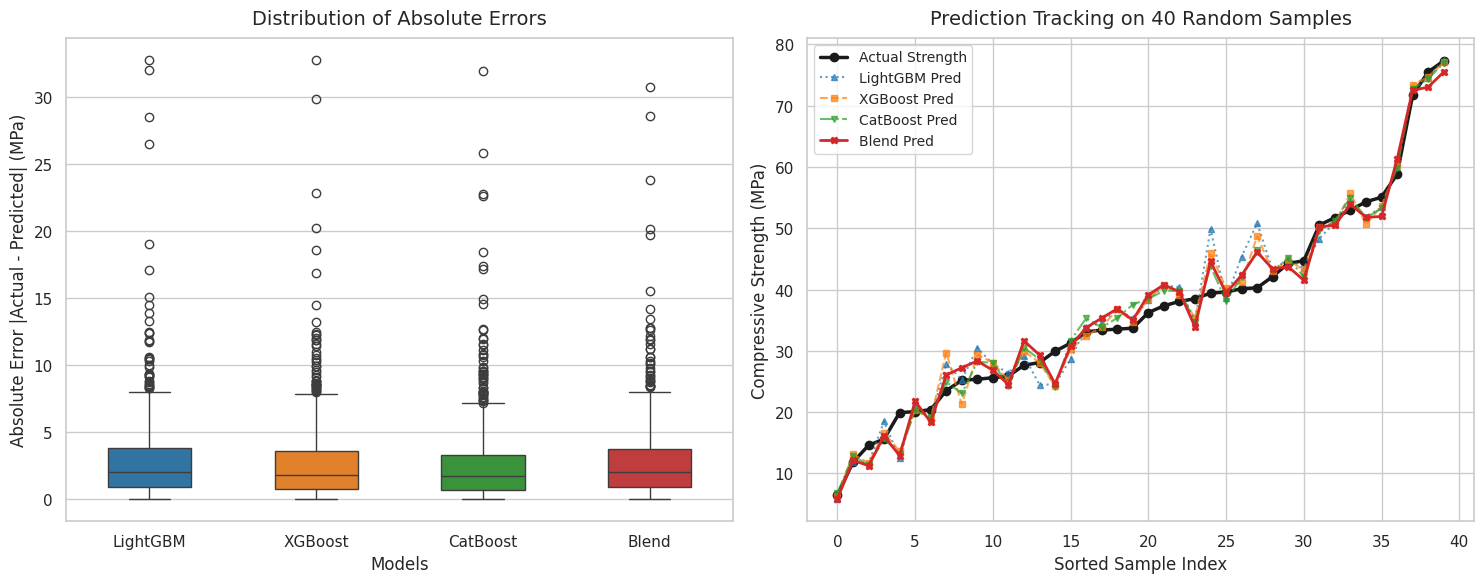

完成'


In [39]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


print("正在生成多模型对比评估图表...")

os.makedirs('figs', exist_ok=True)
save = lambda name: plt.savefig(f'figs/{name}.png', dpi=300, bbox_inches='tight')


sns.set_theme(style="whitegrid", palette="muted")
fig, ax = plt.subplots(1, 2, figsize=(15, 6))


compare_models = {
    'LightGBM': oof_lgb,
    'XGBoost': oof_xgb,
    'CatBoost': oof_cat,
    'Blend': oof_blend
}


y_true_array = y.values if isinstance(y, pd.Series) else y


abs_errors = []
labels = []
for name, pred in compare_models.items():
   
    abs_errors.extend(np.abs(y_true_array - pred))
    labels.extend([name] * len(y_true_array))


df_errors = pd.DataFrame({'Model': labels, 'Absolute Error (MPa)': abs_errors})

sns.boxplot(x='Model', y='Absolute Error (MPa)', data=df_errors, ax=ax[0], 
            palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], width=0.5)
ax[0].set_title('Distribution of Absolute Errors', fontsize=14, pad=10)
ax[0].set_ylabel('Absolute Error |Actual - Predicted| (MPa)', fontsize=12)
ax[0].set_xlabel('Models', fontsize=12)


np.random.seed(42)
sample_indices = np.random.choice(range(len(y_true_array)), size=40, replace=False)


sample_indices = sample_indices[np.argsort(y_true_array[sample_indices])]
y_true_subset = y_true_array[sample_indices]


ax[1].plot(range(40), y_true_subset, 'k-o', label='Actual Strength', linewidth=2.5, markersize=6)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['^', 's', 'v', 'X']
line_styles = [':', '--', '-.', '-'] # 融合模型用实线突出显示

for i, (name, pred) in enumerate(compare_models.items()):
    y_pred_subset = pred[sample_indices]
    alpha_val = 1.0 if name == 'Blend' else 0.7 # 重点突出 Blend 融合模型
    lw_val = 2.0 if name == 'Blend' else 1.5
    
    ax[1].plot(range(40), y_pred_subset, linestyle=line_styles[i], marker=markers[i], 
               color=colors[i], label=f'{name} Pred', alpha=alpha_val, linewidth=lw_val, markersize=5)

ax[1].set_title('Prediction Tracking on 40 Random Samples', fontsize=14, pad=10)
ax[1].set_ylabel('Compressive Strength (MPa)', fontsize=12)
ax[1].set_xlabel('Sorted Sample Index', fontsize=12)
ax[1].legend(fontsize=10)

plt.tight_layout()
save('multi_model_regression_comparison')
plt.show() 
plt.close()

print("完成'")

正在绘制 残差分布密度图 / 累积误差 CDF 曲线...


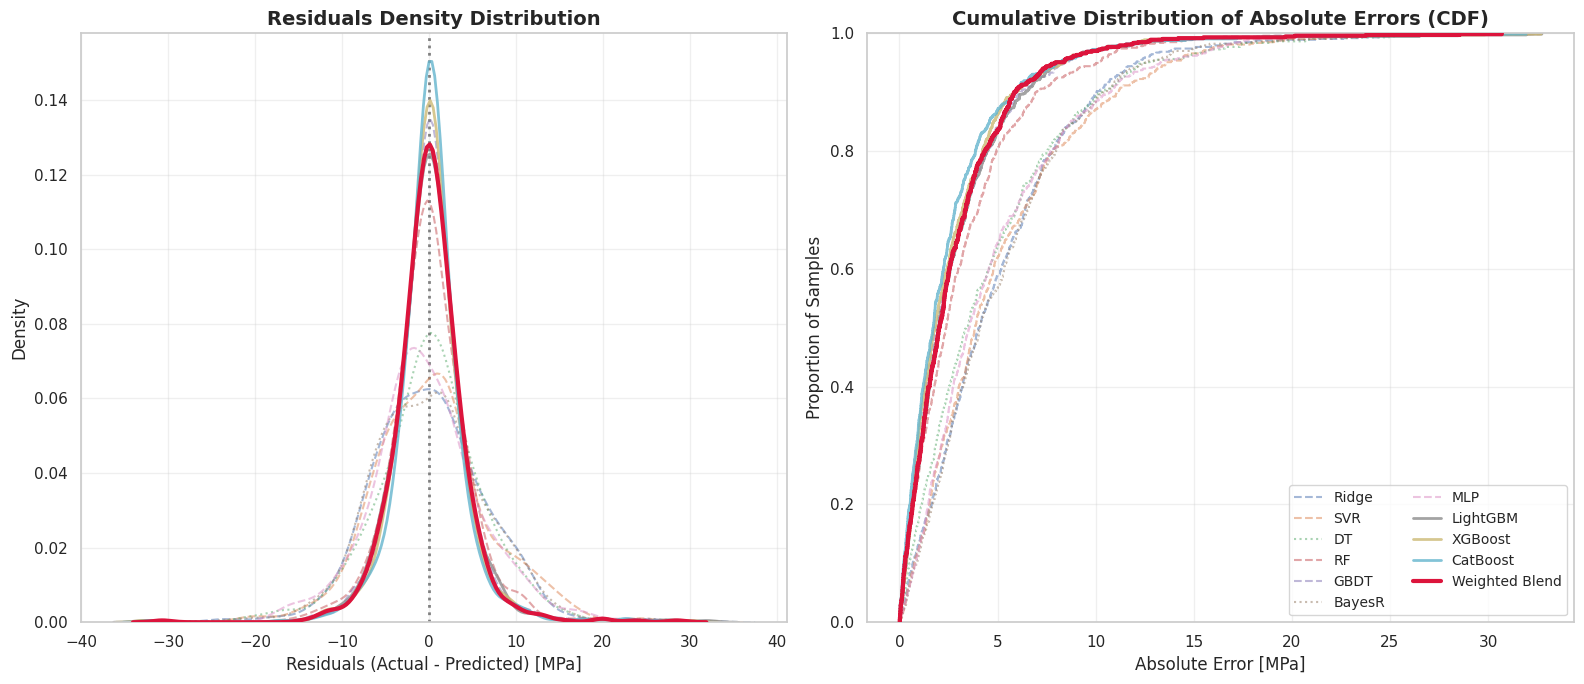

完成


In [40]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plot_data = [
    
    (oof_lr,   'Ridge',  {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_svm,  'SVR',    {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_dt,   'DT',     {'lw': 1.5, 'alpha': 0.5, 'linestyle': ':'}),
    (oof_rf,   'RF',     {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_gbdt, 'GBDT',   {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_nb,   'BayesR', {'lw': 1.5, 'alpha': 0.5, 'linestyle': ':'}),
    (oof_mlp,  'MLP',    {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    
  
    (oof_lgb,  'LightGBM', {'lw': 2, 'alpha': 0.8}),
    (oof_xgb,  'XGBoost',  {'lw': 2, 'alpha': 0.8}),
    (oof_cat,  'CatBoost', {'lw': 2, 'alpha': 0.8}),
    
    
    (oof_blend, 'Weighted Blend', {'lw': 3, 'alpha': 1.0, 'color': 'crimson', 'zorder': 10}),
]


os.makedirs('figs', exist_ok=True)
save = lambda name: plt.savefig(f'figs/{name}.png', dpi=300, bbox_inches='tight')


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 7))


print("正在绘制 残差分布密度图 / 累积误差 CDF 曲线...")


ax[0].axvline(0, color='gray', linestyle=':', lw=2, label='Zero Error') 

for prob, label, kwargs in plot_data:
    residuals = y - prob  
    sns.kdeplot(residuals, label=label, ax=ax[0], **kwargs)

ax[0].set_title('Residuals Density Distribution', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Residuals (Actual - Predicted) [MPa]', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)
ax[0].grid(True, alpha=0.3)

for prob, label, kwargs in plot_data:
    abs_errors = np.abs(y - prob) # 计算绝对误差
    sns.ecdfplot(abs_errors, label=label, ax=ax[1], **kwargs)

ax[1].set_title('Cumulative Distribution of Absolute Errors (CDF)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Absolute Error [MPa]', fontsize=12)
ax[1].set_ylabel('Proportion of Samples', fontsize=12)
ax[1].grid(True, alpha=0.3)


ax[1].legend(loc='lower right', fontsize=10, ncol=2)

# 4. 保存与展示
plt.tight_layout()
save('regression_residuals_cdf_all_models')
plt.show()
plt.close()

print("完成")

>>> [1/3] Loading data and applying SCI-level terminology...
>>> [2/3] Training CatBoost model for interpretation...
>>> [3/3] Generating professional SHAP plots...


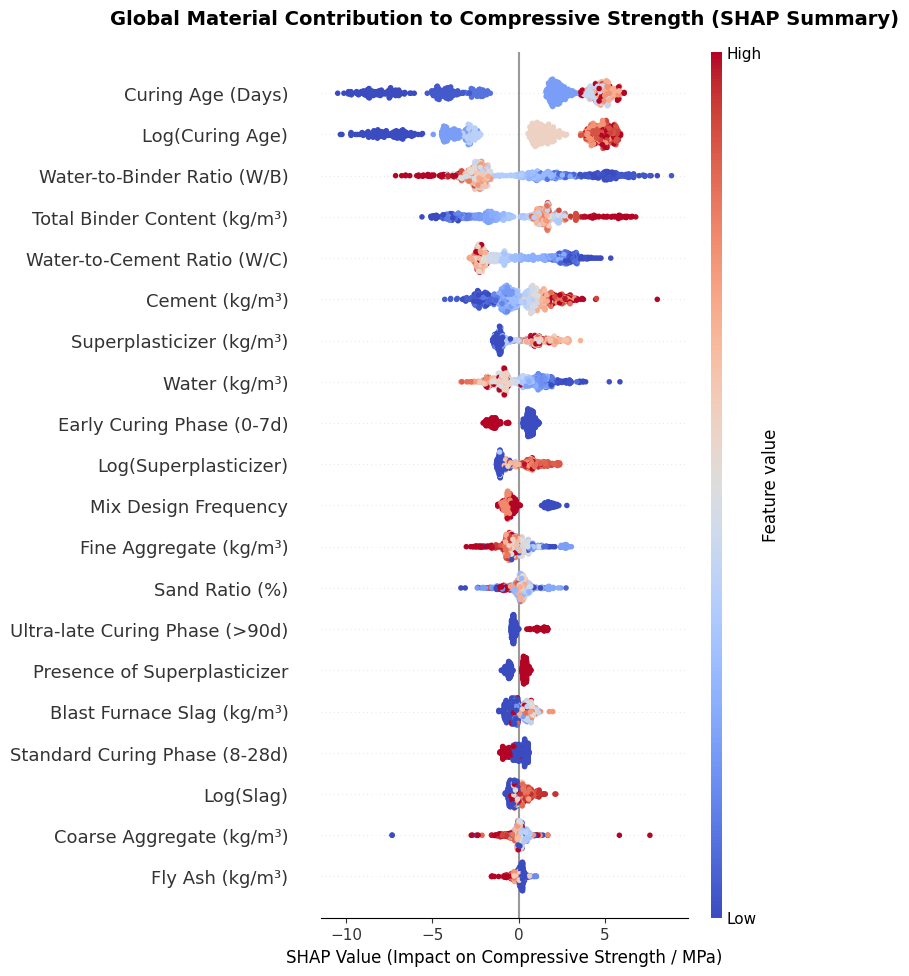

<Figure size 900x700 with 0 Axes>

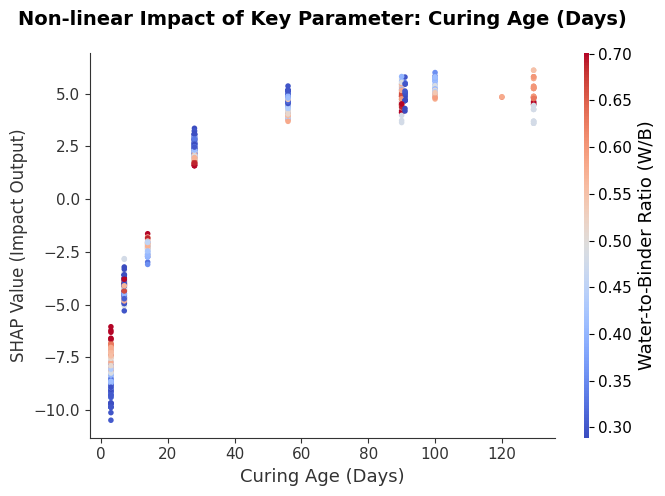

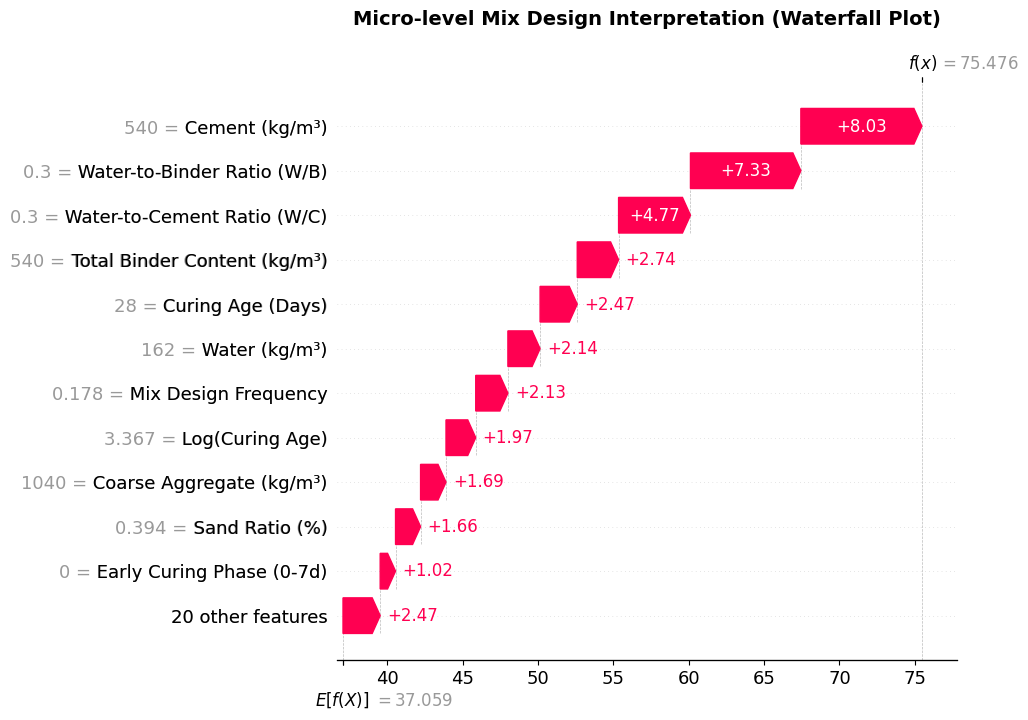

完成


In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from catboost import CatBoostRegressor
import warnings
import logging


warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True 


plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica', 'sans-serif']


sci_engineering_dict = {
    
    'Cement': 'Cement (kg/m³)',
    'Blast Furnace Slag': 'Blast Furnace Slag (kg/m³)',
    'Fly Ash': 'Fly Ash (kg/m³)',
    'Water': 'Water (kg/m³)',
    'Superplasticizer': 'Superplasticizer (kg/m³)',
    'Coarse Aggregate': 'Coarse Aggregate (kg/m³)',
    'Fine Aggregate': 'Fine Aggregate (kg/m³)',
    'Age (day)': 'Curing Age (Days)',
    
   
    'Water_Cement_Ratio': 'Water-to-Cement Ratio (W/C)',
    'Total_Binder': 'Total Binder Content (kg/m³)',
    'Water_Binder_Ratio': 'Water-to-Binder Ratio (W/B)',
    'Sand_Ratio': 'Sand Ratio (%)',
    
   
    'has_Superplasticizer': 'Presence of Superplasticizer',
    'has_FlyAsh': 'Presence of Fly Ash',
    'mix_type_freq': 'Mix Design Frequency',
    
    
    'Age_Phase_OHE_0.0': 'Early Curing Phase (0-7d)',
    'Age_Phase_OHE_1.0': 'Standard Curing Phase (8-28d)',
    'Age_Phase_OHE_2.0': 'Late Curing Phase (29-90d)',
    'Age_Phase_OHE_3.0': 'Ultra-late Curing Phase (>90d)',
    
    
    'Age (day)_log1p': 'Log(Curing Age)',
    'Superplasticizer_log1p': 'Log(Superplasticizer)',
    'Fly Ash_log1p': 'Log(Fly Ash)',
    'Blast Furnace Slag_log1p': 'Log(Slag)'
}


print(">>> [1/3] Loading data and applying SCI-level terminology...")
df_saved = pd.read_csv('train_fe_final.csv')

target_col = 'Concrete compressive strength'
drop_cols = [target_col, 'Strength_Level']


X_raw = df_saved.drop(columns=[col for col in drop_cols if col in df_saved.columns])
X_shap = X_raw.rename(columns=sci_engineering_dict).astype(float)
y = df_saved[target_col].astype(float)


print(">>> [2/3] Training CatBoost model for interpretation...")
m_cat = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=False, random_state=42)
m_cat.fit(X_shap, y)


print(">>> [3/3] Generating professional SHAP plots...")
os.makedirs('figs', exist_ok=True)
save = lambda name: plt.savefig(f'figs/{name}.png', dpi=300, bbox_inches='tight')

explainer = shap.TreeExplainer(m_cat)
shap_values = explainer.shap_values(X_shap)
shap_v = shap_values[0] if isinstance(shap_values, list) else shap_values


plt.figure(figsize=(12, 10))
shap.summary_plot(shap_v, X_shap, show=False, cmap='coolwarm')
plt.title('Global Material Contribution to Compressive Strength (SHAP Summary)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Compressive Strength / MPa)', fontsize=12)
save('shap_sci_summary')
plt.show()


top_feat_idx = np.abs(shap_v).mean(axis=0).argmax()
top_feat_name = X_shap.columns[top_feat_idx]

plt.figure(figsize=(9, 7))
shap.dependence_plot(top_feat_name, shap_v, X_shap, show=False, cmap='coolwarm')
plt.title(f'Non-linear Impact of Key Parameter: {top_feat_name}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('SHAP Value (Impact Output)', fontsize=12)
safe_name = str(top_feat_name).replace("/", "_").replace(" ", "_").replace("(", "").replace(")", "").replace(">", "gt")
save(f'shap_sci_dependence_{safe_name}')
plt.show()


plt.figure(figsize=(12, 8))
ev = explainer.expected_value
if isinstance(ev, (list, np.ndarray)): ev = ev[0]

shap_exp = shap.Explanation(
    values=shap_v[0], 
    base_values=ev, 
    data=X_shap.iloc[0].values, 
    feature_names=list(X_shap.columns)
)
shap.waterfall_plot(shap_exp, max_display=12, show=False)
plt.title('Micro-level Mix Design Interpretation (Waterfall Plot)', fontsize=14, fontweight='bold', pad=20)
save('shap_sci_waterfall')
plt.show()

print("完成")